<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
ls

drive/  sample_data/


In [120]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling2D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle




In [121]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'angry': #Folder contain Glacier Images get the '2' class label.
            label = 'angry'
        elif labels == 'calm':
            label = 'calm'
        elif labels == 'disgust':
            label = 'disgust'
        elif labels == 'fearful':
            label = 'fearful'
        elif labels == 'happy':
            label = 'happy'
        elif labels == 'neutral':
            label = 'neutral'
        elif labels == 'sad':
            label = 'sad'
        elif labels == 'surprised':
            label = 'surprised'
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(75,75)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {'angry':'angry', 'calm':'calm', 'disgust':'disgust', 'fearful':'fearful', 'happy':'happy', 'neutral':'neutral','sad':'sad','surprised':'surprised'}
    
    return labels[class_code]


In [122]:
Images, Labels = get_images('/content/drive/My Drive/sorted_data/') #Extract the training images from the folders.

# Images = np.array(Images) #converting the list of images to numpy array.
# Labels = np.array(Labels)

In [121]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

AttributeError: ignored

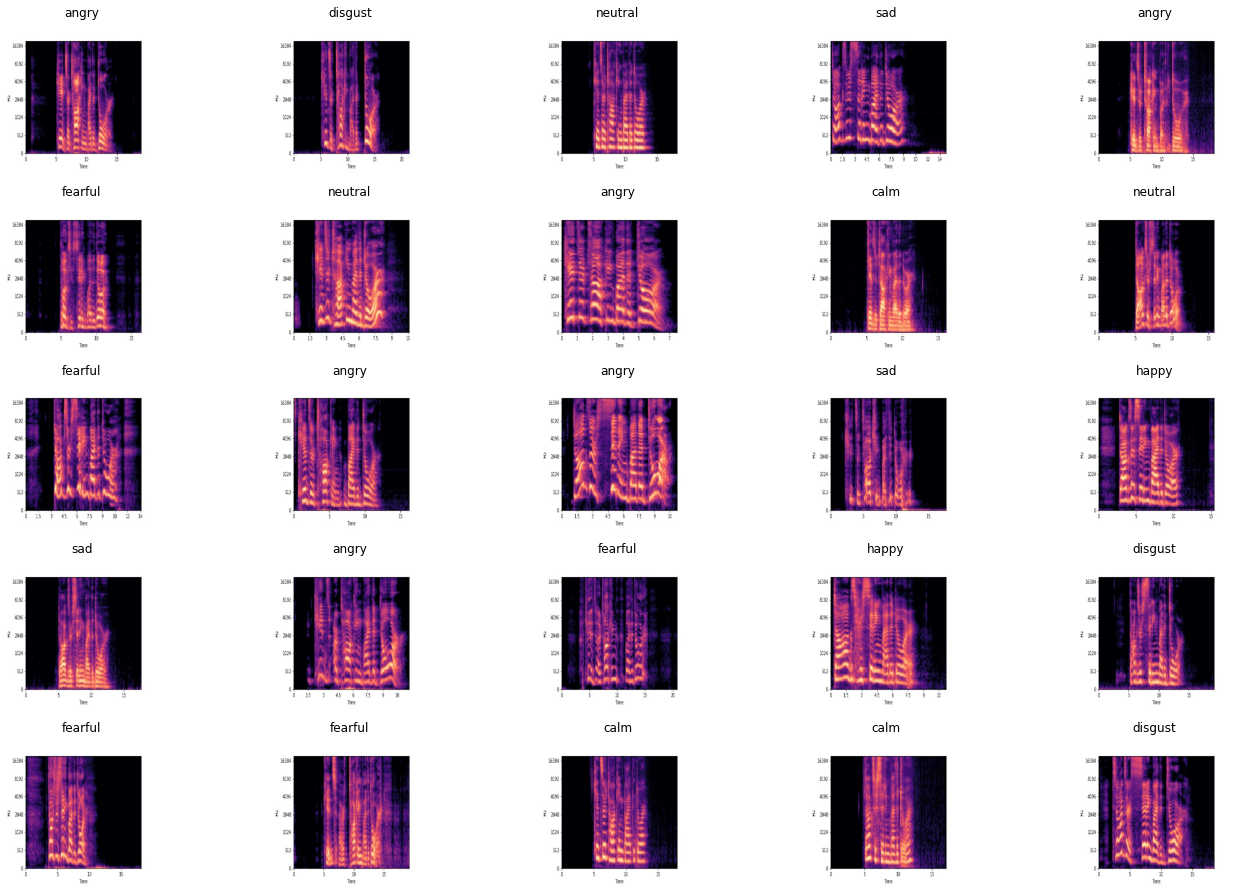

In [6]:
from random import randint

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [123]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(Images, Labels, test_size=0.25,random_state=42, stratify=Labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.25,random_state=42,stratify=y_model)


In [124]:
# Images = np.array(Images) #converting the list of images to numpy array.
# Labels = np.array(Labels)

In [125]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

X_train=np.array(X_train)/255
# y_train = to_categorical(lb.fit_transform(y_train),num_classes=8)

X_test=np.array(X_test)/255
# y_test = to_categorical(lb.fit_transform(y_test),num_classes=8)

X_val=np.array(X_val)/255
# y_val = to_categorical(lb.fit_transform(y_val),num_classes=8)



y_val=np_utils.to_categorical(lb.fit_transform(y_val))
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [126]:
X_test.shape

(360, 75, 75, 3)

In [79]:
X_train.shape

(810, 240, 240, 3)

In [80]:
y_test.shape

(360, 8)

In [ ]:
X_train[90][50]

In [19]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [20]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [40]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [127]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# setting image size
img_rows, img_cols = 75, 75
input_shape= (75,75,3)
model = vgg16.VGG16(weights= 'imagenet', include_top=False, input_shape= input_shape,pooling='max')

In [128]:
# freezing the layers 
for layer in model.layers:
    layer.trainable = False

In [129]:
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [130]:
# adding additional layers for hyperparameter tuning
def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    # top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.25)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(8, activation='softmax')(top_model)
    return top_model

# def layer_adder(bottom_model, num_classes):
#     top_model = bottom_model.output
#     # top_model = GlobalAveragePooling2D()(top_model)
#     top_model = Dense(1024, activation='relu')(top_model)
#     top_model = Dropout(0.1)(top_model)
#     top_model = Dense(512, activation='relu')(top_model)
#     top_model = Dense(256, activation='relu')(top_model)
#     top_model = Dropout(0.1)(top_model)
#     top_model = Dense(128, activation='relu')(top_model)
#     top_model = Flatten()(top_model)
#     top_model = Dense(64, activation='relu')(top_model)
#     top_model = Dense(8, activation='softmax')(top_model)
#     return top_model

In [131]:
from keras.layers import GlobalMaxPooling2D, AveragePooling2D

# pulling together the entire model

num_classes = 8
input=[(None, 240, 240, 3)] 
FC_Head = layer_adder(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)     

In [132]:
# checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# earlystop = EarlyStopping(monitor= 'val_loss', min_delta= 0, patience= 3, verbose = 1, restore_best_weights= True)

# callbacks = [earlystop, checkpoint]
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer =opt, metrics= ['accuracy'])

epochs = 10

history = model.fit(X_train,y_train, batch_size=16,epochs= epochs, validation_data= (X_val,y_val))


Epoch 1/10
51/51 [==============================] - 1s 29ms/step - loss: 2.0646 - accuracy: 0.1617 - val_loss: 1.9935 - val_accuracy: 0.1815
Epoch 2/10
51/51 [==============================] - 1s 18ms/step - loss: 1.9796 - accuracy: 0.2259 - val_loss: 1.9632 - val_accuracy: 0.2519
Epoch 3/10
51/51 [==============================] - 1s 18ms/step - loss: 1.9182 - accuracy: 0.2543 - val_loss: 1.9021 - val_accuracy: 0.3074
Epoch 4/10
51/51 [==============================] - 1s 18ms/step - loss: 1.8535 - accuracy: 0.3123 - val_loss: 1.8456 - val_accuracy: 0.3037
Epoch 5/10
51/51 [==============================] - 1s 18ms/step - loss: 1.7968 - accuracy: 0.3247 - val_loss: 1.8279 - val_accuracy: 0.3667
Epoch 6/10
51/51 [==============================] - 1s 18ms/step - loss: 1.7583 - accuracy: 0.3210 - val_loss: 1.7735 - val_accuracy: 0.3481
Epoch 7/10
51/51 [==============================] - 1s 18ms/step - loss: 1.7125 - accuracy: 0.3654 - val_loss: 1.7715 - val_accuracy: 0.3333
Epoch 8/10
51

In [133]:
from keras.applications import inception_v3


imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False, input_shape=(75,75,3))
imagenet_new=imagenet.output
new_model = Sequential()
new_model.add(imagenet)
new_model.add(Flatten())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dropout(0.1))
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(8,activation='softmax')) #final layer with softmax activation
new_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# new_model.load_weights('/content/new_model.h5')

In [134]:
for layer in new_model.layers[:1]:
    layer.trainable=False

In [135]:

# step_size_train=train_generator.n//train_generator.batch_size
history = new_model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=10,
          validation_data=(X_val, y_val))

Epoch 1/20
81/81 [==============================] - 5s 63ms/step - loss: 2.1860 - accuracy: 0.1136 - val_loss: 8.5903 - val_accuracy: 0.1333
Epoch 2/20
81/81 [==============================] - 3s 35ms/step - loss: 2.0876 - accuracy: 0.1296 - val_loss: 2.0736 - val_accuracy: 0.1000
Epoch 3/20
81/81 [==============================] - 3s 35ms/step - loss: 2.0761 - accuracy: 0.1321 - val_loss: 3.4891 - val_accuracy: 0.1370
Epoch 4/20
81/81 [==============================] - 3s 35ms/step - loss: 2.0751 - accuracy: 0.1333 - val_loss: 2.1816 - val_accuracy: 0.1481
Epoch 5/20
81/81 [==============================] - 3s 35ms/step - loss: 2.0716 - accuracy: 0.1395 - val_loss: 2.3040 - val_accuracy: 0.1370
Epoch 6/20
81/81 [==============================] - 3s 35ms/step - loss: 2.0515 - accuracy: 0.1642 - val_loss: 3.8293 - val_accuracy: 0.2185
Epoch 7/20
81/81 [==============================] - 3s 35ms/step - loss: 2.0520 - accuracy: 0.1790 - val_loss: 2.6354 - val_accuracy: 0.1704
Epoch 8/20
81